# Tutorial 5d - User-defined Optimization Operands

### November 2024

This tutorial demonstrates how to create a user-defined optimization metric in Optiland. This allows for the optimization of essentially any custom metric, providing flexibility to tailor the optimization process to specific needs. By the end of this tutorial, you will be able to:

- Define custom optimization metrics.
- Integrate these metrics into the Optiland optimization framework.
- Apply the custom metrics to optimize an optical system.

In this example, we will create a custom metric to optimize a freeform surface such that the spot forms an ellipse on the image plane. In particular, we will enforce that the ratio of the ellipse axes equals the golden ratio, or ≈1.618.

All operands, or optimization metrics, in Optiland are defined in the so-called _operand registry_. By defining, then adding a new metric into this registry, we can use it like any other optimization metric. More details of the operand registry can be found in the documentation or in `optiland.optimization.operand`.

In [1]:
import numpy as np

from optiland import analysis, optic, optimization
from optiland.optimization.operand import operand_registry

We start by defining the function that computes our custom metric. The only requirement is that the function returns a scalar value. We can perform any analyses we want within the function and we can choose to include any input arguments we wish.

We will define the function `spot_ellipse_ratio`, which traces rays through the provided lens system, then computes the ratio of the major and minor axes of the spot diagram (ray intersection points at the image plane).

In [2]:
def spot_ellipse_ratio(lens):
    """Find the ratio of the major and minor axes for an elliptical spot diagram.

    This function traces rays through the lens and computes the ratio of the major and
    minor axes of the ellipse that best fits the spot diagram.

    Args:
        lens: The lens object.

    Returns:
        The ratio of the major and minor axes of the ellipse.

    """
    rays_out = lens.trace(
        Hx=0,
        Hy=0,
        wavelength=0.55,
        num_rays=15,
        distribution="hexapolar",
    )

    # Extract the x and y coordinates of the rays at last surface = image plane
    x = rays_out.x
    y = rays_out.y

    # Stack x and y to compute the covariance matrix of the points
    points = np.vstack((x, y))
    cov_matrix = np.cov(points)

    # Calculate the eigenvalues of the covariance matrix
    eigenvalues = np.linalg.eigvalsh(cov_matrix)

    # Sort eigenvalues to identify the major and minor axes (a >= b)
    a2, b2 = np.sort(eigenvalues)[::-1]

    # Calculate ratio of major and minor axes
    a = np.sqrt(a2)
    b = np.sqrt(b2)
    ratio = a / b

    return ratio

We now simply add our function to the operand registry, which was imported from `optiland.optimization.operand`. We need to provide the name of the operand and the function itself. We choose the name `'ellipse_ratio'`, which we will use to reference our function later on. Lastly, we may choose to allow overwriting an existing registered function by passing `overwrite=True`. This is useful if you are testing the function and making frequent changes. Without allowing overwriting, an error will be raised.

In [3]:
operand_registry.register("ellipse_ratio", spot_ellipse_ratio, overwrite=True)

Next, we define a simple singlet value with a polynomial surface type on the first surface. Other tutorials (see [here](https://github.com/HarrisonKramer/optiland/blob/master/docs/examples/Tutorial_7c_Freeform_Surfaces.ipynb)) and the documentation elaborate on polynomial surfaces. We will omit those details here.

In [4]:
class Singlet(optic.Optic):
    def __init__(self):
        super().__init__()

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)

        self.add_surface(
            index=1,
            radius=100,
            thickness=5,
            surface_type="polynomial",
            is_stop=True,
            material="SF11",
            coefficients=[],
        )

        self.add_surface(index=2, thickness=100)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=25)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        # add wavelength
        self.add_wavelength(value=0.55, is_primary=True)

We create a view the initial lens.

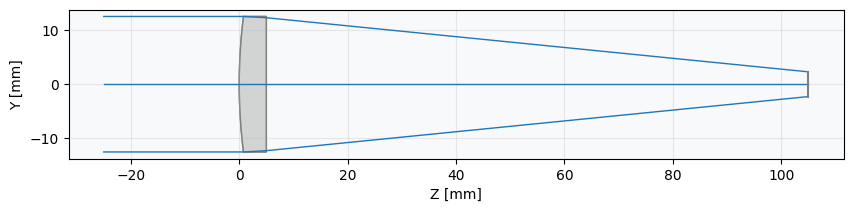

In [5]:
lens = Singlet()
lens.draw()

We now define the optimization problem. We start by defining an OptimizationProblem instance.

In [6]:
problem = optimization.OptimizationProblem()

Next, we add our custom optimization operand to the optimization problem. Recall that we called our new metric `'ellipse_ratio'`. We will specify this as the operand type and set the target to 1.618. Note that we must also provide an `input_data` argument. This is a dictionary in which the keys must match the arguments of our function. As our function only requires the argument `lens`, this is the only input we include. A user-defined function can have as many arguments as you wish, but all must be included in the `input_data` dictionary with their values.

In [7]:
input_data = {"lens": lens}
problem.add_operand(
    operand_type="ellipse_ratio",
    target=1.618,
    weight=1,
    input_data=input_data,
)

We now add variables representing the coefficients of our polynomial surface.

In [8]:
for i in range(2):
    for j in range(2):
        problem.add_variable(
            lens,
            "polynomial_coeff",
            surface_number=1,
            coeff_index=(i, j),
        )

Let's view the details of the optimization problem to see its current, non-optimized status

In [9]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │               0.381924 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ ellipse ratio  │    1.618 │              │              │        1 │       1 │  -0.618 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤══════════════════╤═══════════╤═════════╤══════════════╤══════════════╕
│    │ Variable Type    │   Surface │   Value │ Min. Bound   │ Max. Bound   │
╞════╪═════════════

Finally, we create our optimizer and optimize the system.

In [10]:
optimizer = optimization.OptimizerGeneric(problem)

In [11]:
res = optimizer.optimize(tol=1e-6)

We can optionally view the optimization output details. We see that the optimization was successful and that the function was called 140 times. On the author's computer, the optimization completed in 0.3 seconds.

In [12]:
res

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.610224594082534e-12
        x: [ 3.312e-05 -2.164e-10 -4.314e-10  9.576e-03]
      nit: 5
      jac: [ 1.026e-07  9.535e-14  0.000e+00 -2.927e-04]
     nfev: 140
     njev: 28
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

We now view the optimization problem result. The optimization was indeed a success and we see that our operand has the target value of ≈1.618.

In [13]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            4.61022e-12 │               100 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ ellipse ratio  │    1.618 │              │              │        1 │   1.618 │       0 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤══════════════════╤═══════════╤══════════════╤══════════════╤══════════════╕
│    │ Variable Type    │   Surface │        Value │ Min. Bound   │ Max. Bound   │
╞════╪═══

Lastly, let's view the spot diagram to see if it truly appears elliptical.

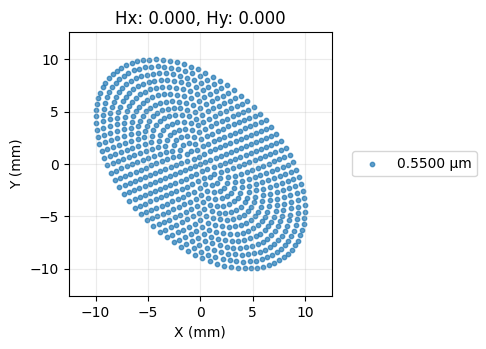

In [14]:
spot = analysis.SpotDiagram(lens, num_rings=15)
spot.view()

Conclusions:

- This tutorial showed how to define a custom optimization operand in Optiland and how to use it within an optimization problem.
- The operand registry defines all optimization operands in Optiland. Adding a user-defined operand to this registry makes it available for optimization.
- An operand function requires only that a scalar output value is generated. The function may have any number of input arguments. The values of the input arguments must be passed as input data to the operand when it is defined for the optimization problem.
- Following the steps here, any arbitrary operand can be optimized within Optiland.